<a href="https://colab.research.google.com/github/AmityaDive/AmityaDive/blob/main/Ads_A_B_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Objective**

This analysis measures the difference in revenue between test group B to group A

Group A  - 1 "organic" item followed bt 4 "paid"

Group B - 4 "paid" followed by 1 "organic"


**Research Questions**

*   Which group has higher RPM?
*   Except for a change paid clicks, is there a difference in orgnic clicks bweteen groups?
*   What are the main conclusions from the test?

**Main Findings**

*   Pageviews divided ~50-50 betweeh two group. Except for march 5th where  group A  had a drop in pageviews. Looks like a bug. Therefore analysis exclude March 5th
*   RPM lift from group A to group B: 21.98%
*   Paid CTR lift from Group A to Group B: 10.66%; Organic CTR lift from Group A to Group B: -53.57%

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
## Loading dataset
dataset_path = '/content/Ads_Test_Data_original.csv'

In [ ]:
# Define the function to reset a DataFrame
def reset_df(file):
    df = pd.read_csv(file)
    df.drop_duplicates(inplace=True)
    df.dropna(inplace=True)
    return df

ads_test_df = reset_df(dataset_path)

ads_test_df.rename(columns=lambda x: x.strip(), inplace=True)

In [ ]:
## Updating data types

ads_test_df.head()
ads_test_df.info()

ads_test_df['revenue'] = ads_test_df['revenue'].str.replace('$', '').astype(float)
ads_test_df.rename(columns={'revenue' : 'revenue_$'},
                              inplace=True)

ads_test_df['date'] = pd.to_datetime(ads_test_df['date'])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126 entries, 0 to 125
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   date               126 non-null    object
 1   publisher_id       126 non-null    int64 
 2   platform           126 non-null    object
 3   group_name         126 non-null    object
 4   pageviews          126 non-null    int64 
 5   visible_pageviews  126 non-null    int64 
 6   sessions           126 non-null    int64 
 7   paid_clicks        126 non-null    int64 
 8   organic_clicks     126 non-null    int64 
 9   revenue            126 non-null    object
 10  total_clicks       126 non-null    int64 
dtypes: int64(7), object(4)
memory usage: 11.0+ KB


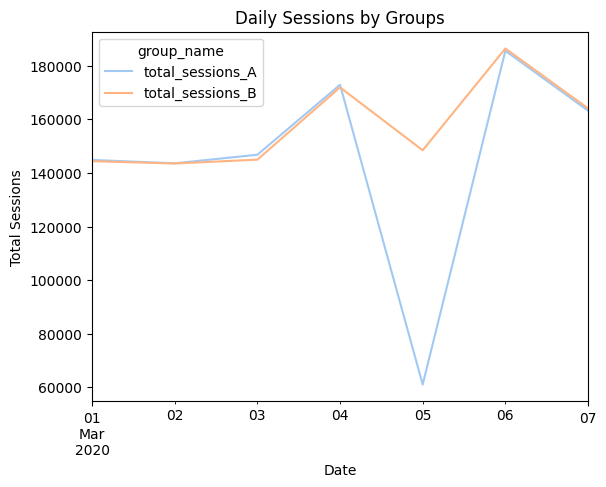

In [ ]:
# daily sessions by groups

# Group by 'date' and 'group_name', then sum 'sessions'
daily_sessions = ads_test_df.groupby(['date', 'group_name'])['sessions'].sum().unstack().reset_index()

# Rename columns for clarity
daily_sessions.rename(columns={'Group_A': 'total_sessions_A', 'Group_B': 'total_sessions_B'}, inplace=True)

# Plot the results
daily_sessions.plot(x='date', y=['total_sessions_A', 'total_sessions_B'], kind='line')
plt.xlabel('Date')
plt.ylabel('Total Sessions')
plt.title('Daily Sessions by Groups')
plt.show()

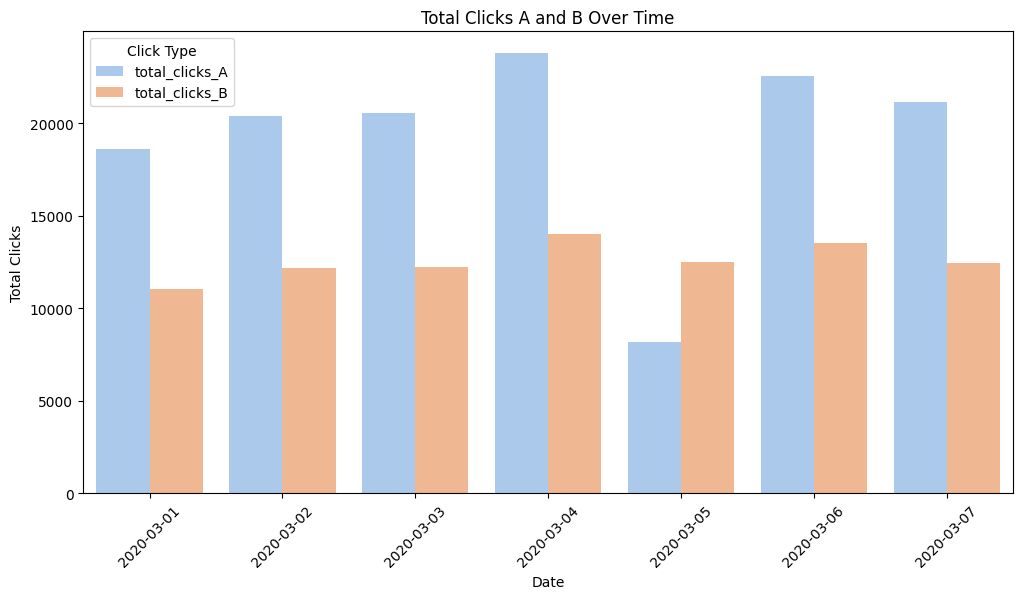

In [ ]:
# daily clicks by groups

# Group by 'date' and 'group_name', then sum 'total_clicks' and unstack
daily_clicks = ads_test_df.groupby(['date', 'group_name'])['total_clicks'].sum().unstack().reset_index()

# Rename columns for clarity
daily_clicks.rename(columns={'Group_A': 'total_clicks_A', 'Group_B': 'total_clicks_B'}, inplace=True)

# Melt the DataFrame from wide to long format
melted = pd.melt(daily_clicks,
                 id_vars=['date'],
                 value_vars=['total_clicks_A', 'total_clicks_B'],
                 var_name='click_type', value_name='total_clicks')

# Create a bar plot
sns.set_palette('pastel')
plt.figure(figsize=(12, 6))
sns.barplot(data=melted, x='date', y='total_clicks', hue='click_type')
plt.title('Total Clicks A and B Over Time')
plt.xlabel('Date')
plt.ylabel('Total Clicks')
plt.xticks(rotation=45)
plt.legend(title='Click Type')
plt.show()

In [ ]:
day_filter = ads_test_df['date'] != '2020-03-05'

ads_test_df_filtered = ads_test_df[day_filter]

In [ ]:
# Adding RPM coloumn

ads_test_df['RPM'] = ads_test_df['revenue_$'] / (ads_test_df['visible_pageviews'] / 1000)

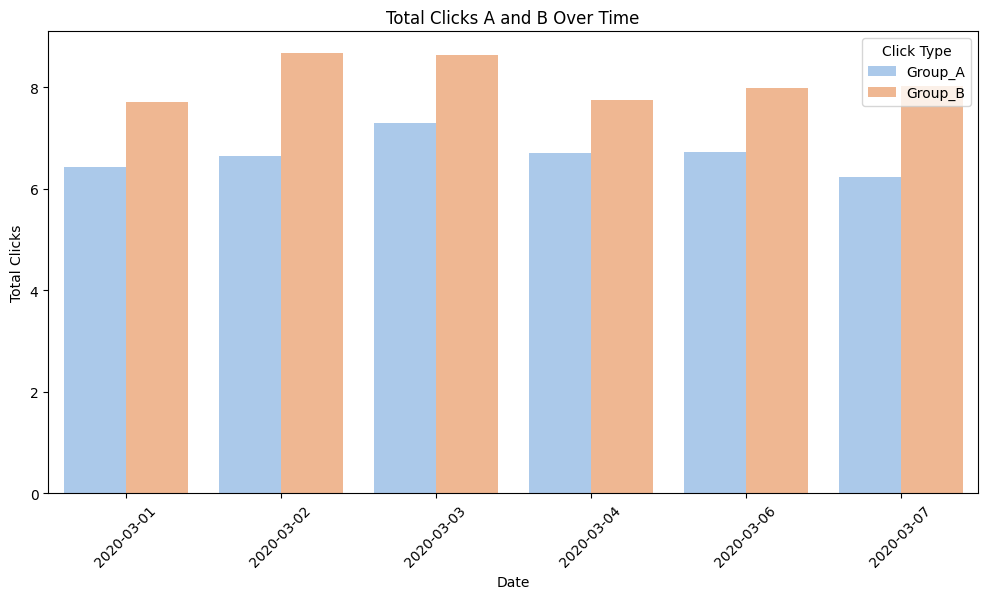

In [ ]:
# average RPM per group
mean_RPM_per_group = ads_test_df_filtered\
.groupby('group_name')\
.agg(average_RPM = ('RPM', 'mean'))


mean_RPM_per_group.reset_index(inplace=True)

# average RPM per day & group
mean_RPM_per_date = ads_test_df_filtered\
.groupby(['date', 'group_name'])\
.agg(average_RPM = ('RPM', 'mean'))

mean_RPM_per_date.reset_index(inplace=True)

# Create a bar plot
sns.set_palette('pastel')
plt.figure(figsize=(12, 6))
sns.barplot(data=mean_RPM_per_date, x='date', y='average_RPM', hue='group_name')
plt.title('Total Clicks A and B Over Time')
plt.xlabel('Date')
plt.ylabel('Total Clicks')
plt.xticks(rotation=45)
plt.legend(title='Click Type')
plt.show()

# pivot RPM by group
pivot_mean_RPM_per_date = mean_RPM_per_date.pivot_table(index = 'date',
                                                       columns = 'group_name',
                                                       values = 'average_RPM',
                                                       aggfunc = 'mean')

In [ ]:
# Lift calculation

pivot_mean_RPM_per_date['%lift'] = ((pivot_mean_RPM_per_date['Group_B'] / pivot_mean_RPM_per_date['Group_A']) - 1) * 100

print('RPM lift from group A to group B: {:.2f}%'.format(pivot_mean_RPM_per_date['%lift'].mean()))

RPM lift from group A to group B: 21.98%


In [ ]:
# Calculate CTR using .assign
CTR_df = ads_test_df_filtered.assign(
          paid_CTR=lambda df: df['paid_clicks'] / df['pageviews'],
          organic_CTR=lambda df: df['organic_clicks'] / df['pageviews'])


# paid CTR per group
CTR_groups_df = CTR_df\
.groupby('group_name')\
.agg(avg_paid_CTR = ('paid_CTR', 'mean'),
     avg_organic_CTR = ('organic_CTR', 'mean'))\
     .reset_index()

CTR_groups_df.set_index('group_name', inplace=True)

CTR_groups_df.reset_index(inplace=True)
CTR_groups_df.set_index('group_name', inplace=True)

# Calculate the lift for paid CTR
paid_CTR_lift = ((CTR_groups_df.loc['Group_B', 'avg_paid_CTR'] - CTR_groups_df.loc['Group_A', 'avg_paid_CTR']) / CTR_groups_df.loc['Group_A', 'avg_paid_CTR']) * 100

# Calculate the lift for organic CTR
organic_CTR_lift = ((CTR_groups_df.loc['Group_B', 'avg_organic_CTR'] - CTR_groups_df.loc['Group_A', 'avg_organic_CTR']) / CTR_groups_df.loc['Group_A', 'avg_organic_CTR']) * 100

print(f'Paid CTR lift from Group A to Group B: {paid_CTR_lift:.2f}%')
print(f'Organic CTR lift from Group A to Group B: {organic_CTR_lift:.2f}%')

Paid CTR lift from Group A to Group B: 10.66%
Organic CTR lift from Group A to Group B: -53.57%
